In [18]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In this article we will try to forecast a time series data. We'll build 2 different model with Python and inspect their results. Models we will use are ARIMA (Autoregressive Integrated Moving Average) and LSTM (Long Short Term Memory Neural Network).

### Read Dataset

In [19]:
df = pd.read_csv("monthly_beer_production_austr.csv")

In [20]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [22]:
df.Month = pd.to_datetime(df.Month)

In [23]:
df = df.set_index("Month")
df.head(20)

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
1956-06-01,64.8
1956-07-01,70.1
1956-08-01,77.3
1956-09-01,79.5


In [24]:
df.index.freq = 'MS'

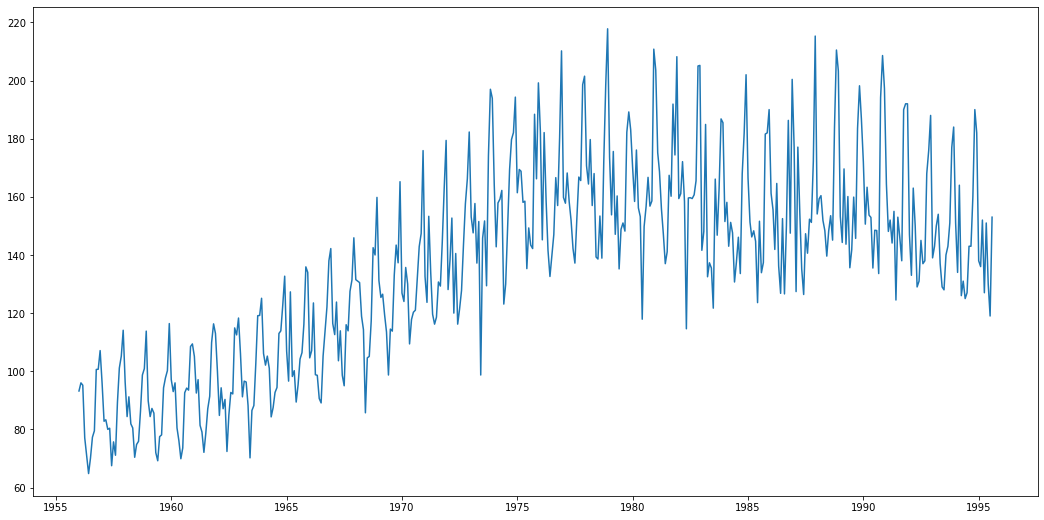

In [25]:
plt.figure(figsize=(18,9))
plt.plot(df.index, df["Monthly beer production"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show();

When we look at plot we can say there is a seasonality in data. That's why we will use SARIMA (Seasonal ARIMA) instead of ARIMA.

Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

There are four seasonal elements that are not part of ARIMA that must be configured; they are:
P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.

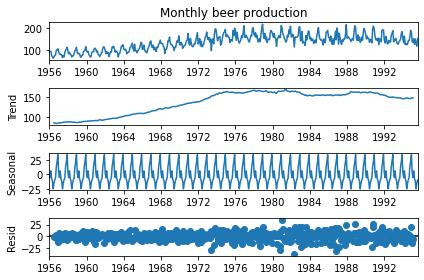

In [26]:
a = seasonal_decompose(df["Monthly beer production"], model = "add")
a.plot();

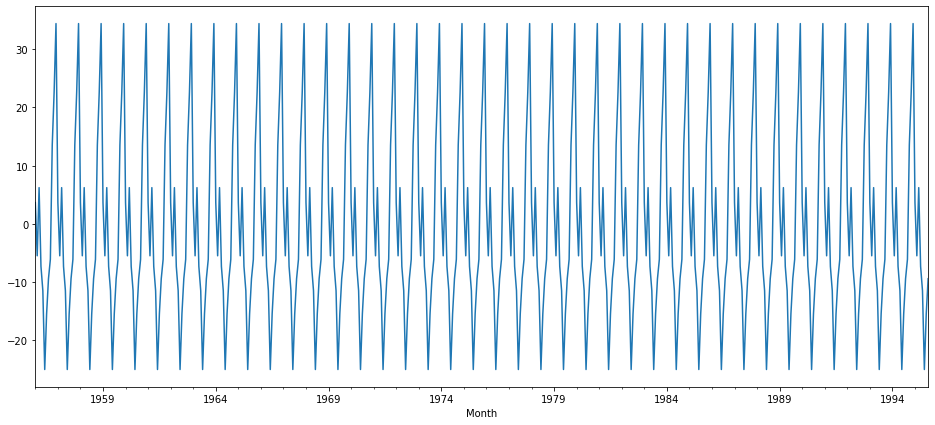

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

### ARIMA Forecast¶

Let's run auto_arima() function to get best p,d,q,P,D,Q values

In [29]:
#auto_arima(df['Monthly beer production'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

As we can see best arima model chosen by auto_arima() is SARIMAX(2, 1, 1)x(4, 0, 3, 12)

Let's split the data into train and test set

In [14]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [15]:
arima_model = SARIMAX(train_data['Monthly beer production'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                    Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -1707.988
Date:                                    Sun, 28 Aug 2022   AIC                           3437.977
Time:                                            14:19:41   BIC                           3483.492
Sample:                                        01-01-1956   HQIC                          3455.895
                                             - 08-01-1994                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1254      0.043     -2.937      0.003      -0.209      -0.042
ar.L2         -0.1711      0.046     -3.691      0.000      -0.262      -0.080
ma.L1         -0.8445      0.028    -30.394      0.000      -0.899      -0.790
ar.S.L12       1.7633      0.120     14.663      0.000       1.528       1.999
ar.S.L24      -1.6255      0.233     -6.976      0.000      -2.082      -1.169
ar.S.L36       0.8049      0.183      4.409      0.000       0.447       1.163
ar.S.L48       0.0561      0.065      0.864      0.388      -0.071       0.183
ma.S.L12      -1.5596      0.131    -11.861      0.000      -1.817      -1.302
ma.S.L24       1.3970      0.221      6.325      0.000       0.964       1.830
ma.S.L36      -0.6648      0.128     -5.208      0.000      -0.915      -0.415
sigma2        84.4174      4.980     16.950      0.000      74.656      94.179
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                41.34
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               4.06   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

1994-09-01    134.036411
1994-10-01    157.756682
1994-11-01    181.704227
1994-12-01    183.553337
1995-01-01    145.009657
1995-02-01    136.886832
1995-03-01    151.262572
1995-04-01    133.199084
1995-05-01    137.847462
1995-06-01    120.552646
1995-07-01    128.478637
1995-08-01    138.809298
Freq: MS, Name: ARIMA Predictions, dtype: float64

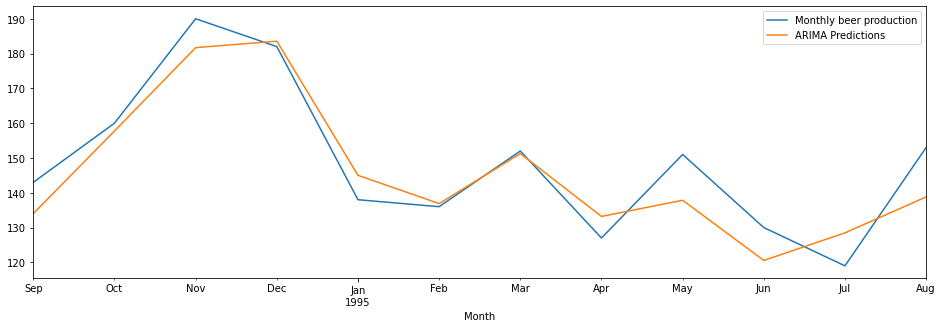

In [17]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [18]:
arima_rmse_error = rmse(test_data['Monthly beer production'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 66.58063791090034
RMSE Error: 8.159695944758012
Mean: 136.39537815126045


In [23]:
test_data['ARIMA_Predictions'] = arima_pred

In [24]:
test

,Monthly beer production,ARIMA_Predictions
Month,,
1994-09-01,143.0,134.036411
1994-10-01,160.0,157.756682
1994-11-01,190.0,181.704227
1994-12-01,182.0,183.553337
1995-01-01,138.0,145.009657
1995-02-01,136.0,136.886832
1995-03-01,152.0,151.262572
1995-04-01,127.0,133.199084
1995-05-01,151.0,137.847462


### LSTM Forecast

First we'll scale our train and test data with MinMaxScaler

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [29]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Before creating LSTM model we should create a Time Series Generator object.

In [30]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

Using TensorFlow backend.

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [32]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
452/452 [==============================] - 9s 11ms/step - loss: 0.0253
Epoch 2/20
452/452 [==============================] - 5s 11ms/step - loss: 0.0136
Epoch 3/20
452/452 [==============================] - 5s 11ms/step - loss: 0.0100
Epoch 4/20
452/452 [==============================] - 5s 11ms/step - loss: 0.0091
Epoch 5/20
452/452 [==============================] - 5s 11ms/step - loss: 0.0084
Epoch 6/20
452/452 [==============================] - 5s 11ms/step - loss: 0.0075
Epoch 7/20
452/452 [==============================] - 5s 10ms/step - loss: 0.0071
Epoch 8/20
452/452 [==============================] - 5s 10ms/step - loss: 0.0069
Epoch 9/20
452/452 [==============================] - 5s 10ms/step - loss: 0.0067
Epoch 10/20
452/452 [==============================] - 5s 10ms/step - loss: 0.0071
Epoch 11/20
452/452 [==============================] - 5s 11ms/step - loss: 0.0071
Epoch 12/20
452/452 [==============================] - 5s 11ms/step - loss: 0.0071
Epoch 13/20
4

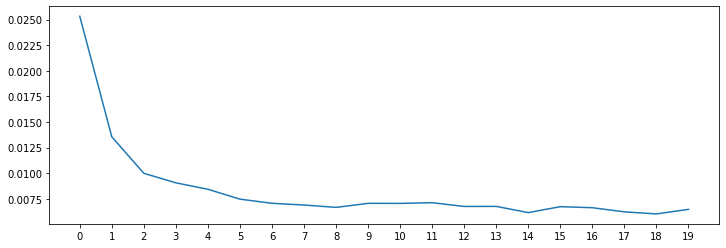

In [33]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [34]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 38ms/step


As you know we scaled our data that's why we have to inverse it to see true predictions.

In [35]:
lstm_predictions_scaled

[array([0.4892526], dtype=float32),
 array([0.5714097], dtype=float32),
 array([0.7053332], dtype=float32),
 array([0.7208468], dtype=float32),
 array([0.53269446], dtype=float32),
 array([0.49508882], dtype=float32),
 array([0.5759444], dtype=float32),
 array([0.41242963], dtype=float32),
 array([0.41716427], dtype=float32),
 array([0.3924459], dtype=float32),
 array([0.4143829], dtype=float32),
 array([0.47102138], dtype=float32)]

In [36]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [37]:
lstm_predictions

array([[139.65564736],
       [152.22568445],
       [172.71597551],
       [175.08955615],
       [146.30225222],
       [140.5485888 ],
       [152.91949682],
       [127.90173351],
       [128.62613271],
       [124.84422149],
       [128.20058443],
       [136.86627175]])

In [38]:
test_data['LSTM_Predictions'] = lstm_predictions

In [39]:
test_data

,Monthly beer production,ARIMA_Predictions,LSTM_Predictions
Month,,,
1994-09-01,143.0,134.036411,139.655647
1994-10-01,160.0,157.756682,152.225684
1994-11-01,190.0,181.704227,172.715976
1994-12-01,182.0,183.553337,175.089556
1995-01-01,138.0,145.009657,146.302252
1995-02-01,136.0,136.886832,140.548589
1995-03-01,152.0,151.262572,152.919497
1995-04-01,127.0,133.199084,127.901734
1995-05-01,151.0,137.847462,128.626133


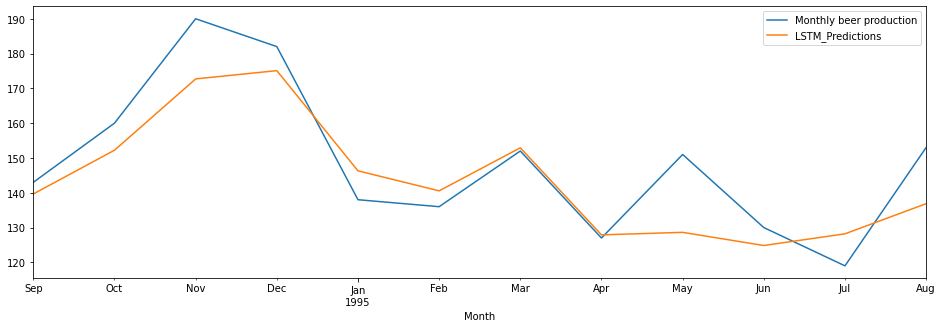

In [40]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [61]:
lstm_rmse_error = rmse(test_data['Monthly beer production'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 115.12599947877499
RMSE Error: 10.72967844246858
Mean: 136.39537815126045


In [62]:
import seaborn as sns

In [63]:
rmse_errors = [arima_rmse_error, lstm_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


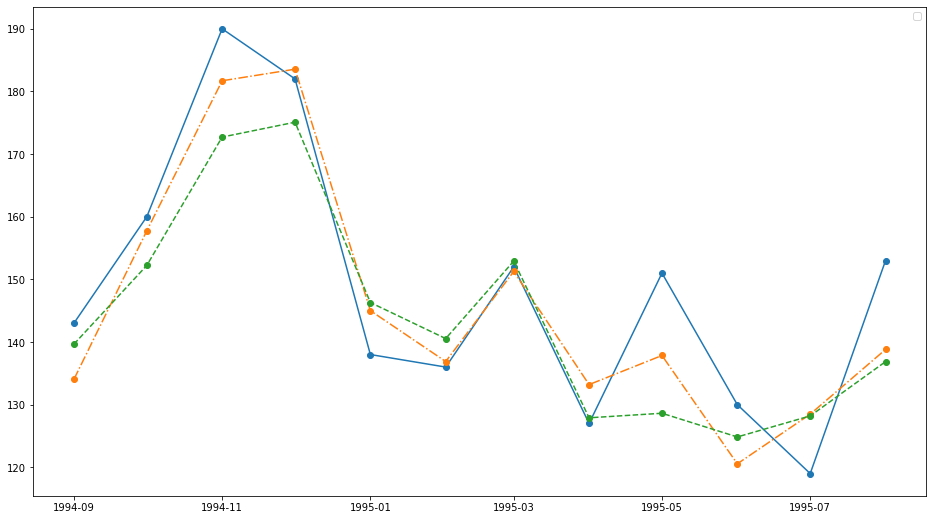

In [64]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Monthly beer production"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.legend()
plt.show()

In [ ]:
print(f"Mean: {test_data['Monthly beer production'].mean()}")
errors

In [57]:
test_data

,Monthly beer production,ARIMA_Predictions,LSTM_Predictions
Month,,,
1994-09-01,143.0,134.036411,139.655647
1994-10-01,160.0,157.756682,152.225684
1994-11-01,190.0,181.704227,172.715976
1994-12-01,182.0,183.553337,175.089556
1995-01-01,138.0,145.009657,146.302252
1995-02-01,136.0,136.886832,140.548589
1995-03-01,152.0,151.262572,152.919497
1995-04-01,127.0,133.199084,127.901734
1995-05-01,151.0,137.847462,128.626133
